## Image classfication on MNIST data set using Deep Net
##############################################

Owner: Arnab Das

Dataset: MNIST

##############################################
### Following steps are performed


*   Get the dataset and preprocess the image 
*   Break the dataset with minibatch size of 128
*   Do the forward pass
*   Calculate the loss and update the prameters
*   check the test data accuracy



In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

#### Provided class to prerocess the data and normalize the pixel values by dividing 255

In [ ]:
class MNISTDataset:
    """'Bare minimum' class to wrap MNIST numpy arrays into a dataset."""
    def __init__(self, train_imgs, train_lbs, test_imgs, test_lbls, batch_size,
                 to01=True, shuffle=True, seed=None):
        """
        Use seed optionally to always get the same shuffling (-> reproducible
        results).
        """
        self.batch_size = batch_size
        self.train_data = train_imgs
        self.train_labels = train_lbs.astype(np.int32)
        self.test_data = test_imgs
        self.test_labels = test_lbls.astype(np.int32)

        if to01:
            # int in [0, 255] -> float in [0, 1]
            self.train_data = self.train_data.astype(np.float32) / 255
            self.test_data = self.test_data.astype(np.float32) / 255

        self.size = self.train_data.shape[0]

        if seed:
            np.random.seed(seed)
        if shuffle:
            self.shuffle_train()
        self.shuffle = shuffle
        self.current_pos = 0

    def next_batch(self):
        """Either gets the next batch, or optionally shuffles and starts a
        new epoch."""
        end_pos = self.current_pos + self.batch_size
        if end_pos < self.size:
            batch = (self.train_data[self.current_pos:end_pos],
                     self.train_labels[self.current_pos:end_pos])
            self.current_pos += self.batch_size
        else:
            # we return what's left (-> possibly smaller batch!) and prepare
            # the start of a new epoch
            batch = (self.train_data[self.current_pos:self.size],
                     self.train_labels[self.current_pos:self.size])
            if self.shuffle:
                self.shuffle_train()
            self.current_pos = 0
            #print("Starting new epoch...")
        return batch

    def shuffle_train(self):
        shuffled_inds = np.arange(self.train_data.shape[0])
        np.random.shuffle(shuffled_inds)
        self.train_data = self.train_data[shuffled_inds]
        self.train_labels = self.train_labels[shuffled_inds]


In [ ]:
class makeDataset:
  def __init__(self, train_imgs, train_lbs, test_imgs, test_lbls, batch_size, repeat= True):
    self.batch_size = batch_size
    self.train_data = train_imgs
    self.train_labels = train_lbs.astype(np.int32)
    self.test_data = test_imgs
    self.test_labels = test_lbls.astype(np.int32)

    self.train_data = (train_images.astype(np.float32) / 255.).reshape((-1, 784))
    self.test_data = (test_images.astype(np.float32) / 255.).reshape((-1, 784))

    self.train_dataset = tf.data.Dataset.from_tensor_slices((self.train_data, self.train_labels))
    self.test_dataset = tf.data.Dataset.from_tensor_slices((self.test_data, self.test_labels))

    if repeat:
      self.doRepeat()

    self.shuffleData()  
    self.makeBatch()


  def doRepeat(self):
    self.train_dataset = self.train_dataset.repeat(2)

  def shuffleData(self):  
    self.train_dataset = self.train_dataset.shuffle(2*self.batch_size)
    self.test_dataset = self.test_dataset.shuffle(2*self.batch_size)

  def makeBatch(self):  
    self.train_dataset = self.train_dataset.batch(self.batch_size)

#### Following the blogpost http://blog.ai.ovgu.de/posts/jens/2019/002_tf20_basic_mnist/index.html 


*   Priting the size of each image
*   Printing the size of reshaped image or imput 
*   Potting example if an image from training set




11493376/11490434 [==============================] - 0s 0us/step
Size of the dataset image is = (28, 28)
Size of the processed dataset image is = (784,)


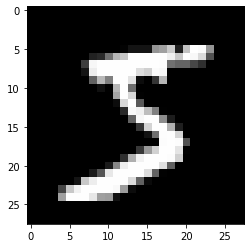

In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print("Size of the dataset image is = {}".format(train_images[0].shape))
plt.imshow(train_images[0],cmap="Greys_r")

data = MNISTDataset(train_images.reshape([-1, 784]), train_labels, 
                    test_images.reshape([-1, 784]), test_labels,
                    batch_size=128)

print("Size of the processed dataset image is = {}".format(data.train_data[0].shape))

In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

data = makeDataset(train_images, train_labels, 
                    test_images, test_labels,
                    batch_size=128,repeat=False)

#### Defining model parameters as tf variables for forward pass and also some hyper parameters

In [ ]:
def initializeParam(step, hid,learning_rate = 0.1):
  train_steps = step
  learning_rate = learning_rate

  W1 = tf.Variable(np.random.randn(784, hid).astype(np.float32)*0.1)
  b1 = tf.Variable(np.zeros(hid, dtype=np.float32))
  W2 = tf.Variable(np.random.randn(hid, 10).astype(np.float32)*0.1)
  b2 = tf.Variable(np.zeros(10, dtype=np.float32))
  W = (W1,W2)
  b = (b1,b2)
  return train_steps,learning_rate, W,b 

### Training phase

In [ ]:
def train(train_steps,learning_rate,W,b):
  Losses = []
  Accuracy = []
  W1,W2 = W
  b1,b2 = b
  for step in range(train_steps):
      img_batch, lbl_batch = data.next_batch()
      with tf.GradientTape() as tape:
          Z1 = tf.matmul(img_batch, W1) + b1
          H1 = tf.nn.relu(Z1)
          logits = tf.matmul(H1, W2) + b2
          xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
              logits=logits, labels=lbl_batch))
      Losses.append(xent)    
      grads = tape.gradient(xent, [W1, b1, W2, b2])
      W1.assign_sub(learning_rate * grads[0])
      b1.assign_sub(learning_rate * grads[1])
      W2.assign_sub(learning_rate * grads[2])
      b2.assign_sub(learning_rate * grads[3])

      preds = tf.argmax(logits, axis=1, output_type=tf.int32)
      acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch),
                              tf.float32))
      Accuracy.append("{}".format(acc*100))
      
      #if not step % 1000:    
          #print("Loss: {} Accuracy: {}".format(xent, acc))
  return Losses,Accuracy    

### Visualizing the Training loss and test accuracy vs test steps 

Help taken from 
https://chrisalbon.com/deep_learning/keras/visualize_loss_history/ and
https://matplotlib.org/api/ticker_api.html#matplotlib.ticker.MultipleLocator

In [ ]:
def visualizeTraining(Losses,Accuracy):
  plt.plot(range(1, train_steps + 1), Losses, 'r--')
  plt.title('Training loss vs steps')
  plt.legend(['Training Loss'])
  plt.xlabel('Step')
  plt.ylabel('Loss')
  plt.show();
  ax = plt.figure().gca()
  ax.plot(range(1, train_steps + 1), Accuracy, 'b-')
  ax.yaxis.set_major_locator(MaxNLocator(integer=True, min_n_ticks = 20))
  plt.title('Training Accuracy vs steps')
  plt.legend(['Training Accuracy'])
  plt.xlabel('Step')
  plt.ylabel('Accuracy')
  plt.show();

### Applying the model on test set and claculating test accuracy

In [ ]:
def testModel(W,b):
  W1,W2 = W
  b1,b2 = b
  out1 = tf.matmul(data.test_data, W1) + b1
  act1 = tf.nn.relu(out1)  
  test_preds = tf.argmax(tf.matmul(act1, W2) + b2, axis=1,
                        output_type=tf.int32)
  acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, data.test_labels),
                              tf.float32))
  print("Test accuracy of the model is = {}%".format(acc*100))
  final_acc = "{:.2f}".format(acc*100)
  return test_preds,final_acc

#### Finding the First miclassified image and plotiing the same
#### Also printing predicted class and actual class




In [ ]:
def visualizeMissclasification(test_preds):  
  first_missclass= np.where(tf.equal(test_preds, data.test_labels) == False)[0][1]
  plt.imshow(test_images[first_missclass],cmap="Greys_r")
  print("Actual label is {}, where as predicted label is {}".format(data.test_labels[first_missclass],test_preds[first_missclass]))

#### Applying the complete model on a two layer NN. Hidden layer consists of 32 units with ReLU activation where as output later is having 10 units.

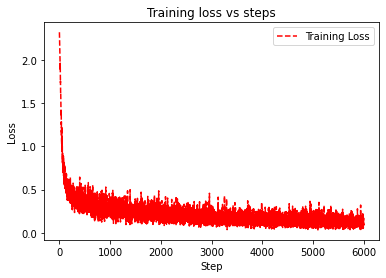

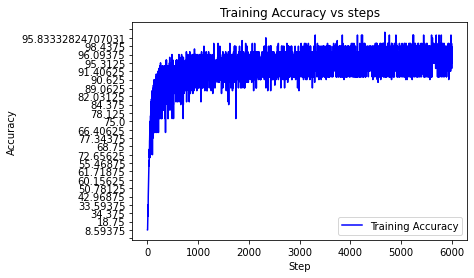

Test accuracy of the model is = 95.8800048828125%
Actual label is 2, where as predicted label is 4


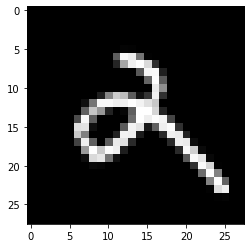

In [ ]:
train_steps,learning_rate, W,b = initializeParam(6000,hid = 32)
Losses,Accuracy = train(train_steps,learning_rate,W,b)
visualizeTraining(Losses,Accuracy)
test_preds,final_acc = testModel(W,b)
visualizeMissclasification(test_preds)

Comparetive study of performance behavior by varying number of units in the hidden layer

Number of units in the hidden layer is = 10
Test accuracy of the model is = 92.43000030517578%
Number of units in the hidden layer is = 20
Test accuracy of the model is = 94.3499984741211%
Number of units in the hidden layer is = 32
Test accuracy of the model is = 95.41000366210938%
Number of units in the hidden layer is = 64
Test accuracy of the model is = 96.17000579833984%
Number of units in the hidden layer is = 128
Test accuracy of the model is = 96.63999938964844%
Number of units in the hidden layer is = 256
Test accuracy of the model is = 96.93000030517578%
Number of units in the hidden layer is = 512
Test accuracy of the model is = 97.29999542236328%
Number of units in the hidden layer is = 1024
Test accuracy of the model is = 97.56999969482422%


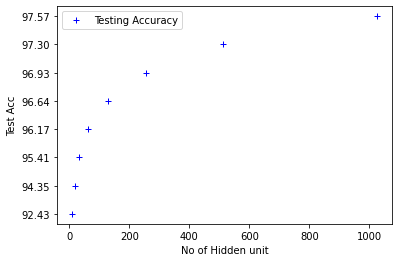

In [ ]:
AccsVsHUnit = []
for hUnit in [10,20,32,64,128,256, 512,1024]:
  print("Number of units in the hidden layer is = {}".format(hUnit))
  train_steps,learning_rate, W,b = initializeParam(5000,hid = hUnit)
  Losses,Accuracy = train(train_steps,learning_rate,W,b)
  test_preds,final_acc = testModel(W,b)
  AccsVsHUnit.append(final_acc)

plt.plot([10,20,32,64,128,256,512,1024], AccsVsHUnit, 'b+')
plt.legend(['Testing Accuracy'])
plt.xlabel('No of Hidden unit')
plt.ylabel('Test Acc')
plt.show();



---


## Extending the Model to 3 layer(2 Hidden + Output Layer) NN.

In [ ]:
train_steps = 5000
learning_rate = 0.1
W1 = tf.Variable(np.random.randn(784, 1024).astype(np.float32)*0.1)
b1 = tf.Variable(np.zeros(1024, dtype=np.float32))
W2 = tf.Variable(np.random.randn(1024, 256).astype(np.float32)*0.1)
b2 = tf.Variable(np.zeros(256, dtype=np.float32))
W3 = tf.Variable(np.random.randn(256, 10).astype(np.float32)*0.1)
b3 = tf.Variable(np.zeros(10, dtype=np.float32))

for step in range(train_steps):
  img_batch, lbl_batch = data.next_batch()
  with tf.GradientTape() as tape:
    Z1 = tf.matmul(img_batch, W1) + b1
    H1 = tf.nn.relu(Z1)
    Z2 = tf.matmul(H1, W2) + b2
    H2 = tf.nn.relu(Z2)
    logits = tf.matmul(H2, W3) + b3
    xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
              logits=logits, labels=lbl_batch))    
    grads = tape.gradient(xent, [W1, b1, W2, b2, W3, b3])
    W1.assign_sub(learning_rate * grads[0])
    b1.assign_sub(learning_rate * grads[1])
    W2.assign_sub(learning_rate * grads[2])
    b2.assign_sub(learning_rate * grads[3])
    W3.assign_sub(learning_rate * grads[4])
    b3.assign_sub(learning_rate * grads[5])

    preds = tf.argmax(logits, axis=1, output_type=tf.int32)
    acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch),
                              tf.float32))
      
    if not step % 1000:
      print("Loss: {} Accuracy: {}".format(xent, acc))

out1 = tf.matmul(data.test_data, W1) + b1
act1 = tf.nn.relu(out1)
out2 = tf.matmul(act1, W2) + b2
act2 = tf.nn.relu(out2)   
test_preds = tf.argmax(tf.matmul(act2, W3) + b3, axis=1,
                        output_type=tf.int32)
acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, data.test_labels),
                              tf.float32))
print("Test accuracy of the model is = {}%".format(acc*100))
final_acc = "{}".format(acc*100)


Loss: 3.906895160675049 Accuracy: 0.0859375
Loss: 0.09910843521356583 Accuracy: 0.96875
Loss: 0.05457227677106857 Accuracy: 0.984375
Loss: 0.02727457694709301 Accuracy: 0.9921875
Loss: 0.013405030593276024 Accuracy: 1.0
Test accuracy of the model is = 97.54999542236328%


### Training 2 layer NN on Sigmoid unit in hidden layer

In [ ]:
def train_sigmoid(train_steps,learning_rate,W,b):
  Losses = []
  Accuracy = []
  W1,W2 = W
  b1,b2 = b
  for step in range(train_steps):
      img_batch, lbl_batch = data.next_batch()
      with tf.GradientTape() as tape:
          hidden_out = tf.matmul(img_batch, W1) + b1
          activation = tf.nn.sigmoid(hidden_out)
          logits = tf.matmul(activation, W2) + b2
          xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
              logits=logits, labels=lbl_batch))
      Losses.append(xent)    
      grads = tape.gradient(xent, [W1, b1, W2, b2])
      W1.assign_sub(learning_rate * grads[0])
      b1.assign_sub(learning_rate * grads[1])
      W2.assign_sub(learning_rate * grads[2])
      b2.assign_sub(learning_rate * grads[3])

      preds = tf.argmax(logits, axis=1, output_type=tf.int32)
      acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch),
                              tf.float32))
      Accuracy.append("{}".format(acc*100))
      
      #if not step % 1000:    
          #print("Loss: {} Accuracy: {}".format(xent, acc))
  return Losses,Accuracy    

#### Testing function on Sigmoid hidden unit

In [ ]:
def testModel_sigmoid(W,b):
  W1,W2 = W
  b1,b2 = b
  out1 = tf.matmul(data.test_data, W1) + b1
  act1 = tf.nn.sigmoid(out1)  
  test_preds = tf.argmax(tf.matmul(act1, W2) + b2, axis=1,
                        output_type=tf.int32)
  acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, data.test_labels),
                              tf.float32))
  print("Test accuracy of the model is = {}%".format(acc*100))
  final_acc = "{:.2f}".format(acc*100)
  return test_preds,float(final_acc)

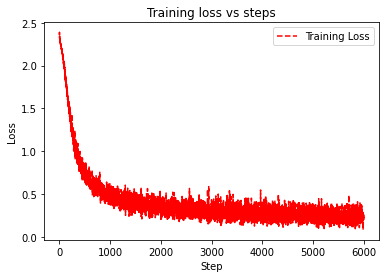

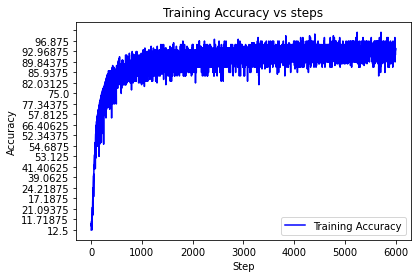

Test accuracy of the model is = 93.55000305175781%
Actual label is 4, where as predicted label is 6


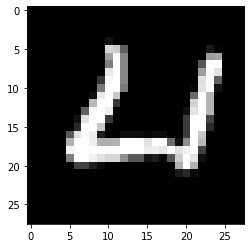

In [ ]:
train_steps,learning_rate, W,b = initializeParam(6000,hid = 32)
Losses,Accuracy = train_sigmoid(train_steps,learning_rate,W,b)
visualizeTraining(Losses,Accuracy)
test_preds,final_acc = testModel_sigmoid(W,b)
visualizeMissclasification(test_preds)

**visualization using different number of sigoid hidden units**

Number of units in the hidden layer is = 10
Test accuracy of the model is = 91.50999450683594%
Number of units in the hidden layer is = 20
Test accuracy of the model is = 92.9000015258789%
Number of units in the hidden layer is = 32
Test accuracy of the model is = 93.08000183105469%
Number of units in the hidden layer is = 64
Test accuracy of the model is = 93.33000183105469%
Number of units in the hidden layer is = 128
Test accuracy of the model is = 93.1500015258789%
Number of units in the hidden layer is = 256
Test accuracy of the model is = 93.0999984741211%
Number of units in the hidden layer is = 512
Test accuracy of the model is = 93.0199966430664%
Number of units in the hidden layer is = 1024
Test accuracy of the model is = 93.18000030517578%


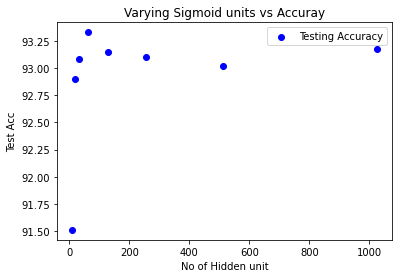

In [ ]:
AccsVsHUnit_sigmoid = []
for hUnit in [10,20,32,64,128,256, 512,1024]:
  print("Number of units in the hidden layer is = {}".format(hUnit))
  train_steps,learning_rate, W,b = initializeParam(5000,hid = hUnit)
  Losses,Accuracy = train_sigmoid(train_steps,learning_rate,W,b)
  test_preds,final_acc = testModel_sigmoid(W,b)
  AccsVsHUnit_sigmoid.append(final_acc)

fig, ax = plt.subplots()
ax.scatter([10,20,32,64,128,256,512,1024], AccsVsHUnit_sigmoid, color='blue')
ax.legend(['Testing Accuracy'])
ax.set_title('Varying Sigmoid units vs Accuray')
ax.set_xlabel('No of Hidden unit')
ax.set_ylabel('Test Acc')
plt.show();

**Observations**

** It is observed from the above experiments that,

1. when SIGMOID activation is used for hidden layer the accuracy is less when 
compared to the ReLU activation

2. when SIGMOID activation is used and by varying the number of hidden units the accuracy is first increased and then a decreasing trend is obserbved

3. In case of ReLU units the accuracy goes up with the number of neurons
**

In [ ]:
np.random.randn(5, 2)

array([[-1.64819275,  0.02838865],
       [ 0.56842459,  1.03179078],
       [-0.32884209,  2.04525489],
       [ 0.82792431,  0.02772747],
       [-1.75231841,  0.94331163]])